In [1]:
import pandas as pd
import numpy as np
import json
import requests
import censusdata
from census import Census
from us import states
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import statsmodels.formula.api as sm
import seaborn as sn
from bs4 import BeautifulSoup

# Covid-19 Vaccination Rate Analysis

## The Motivation Section

At the time of writing, the coronavirus pandemic has resulted in 3,687,589 deaths globally, according to the WHO, with [some analysts](https://www.nytimes.com/interactive/2021/05/25/world/asia/india-covid-death-estimates.html#:~:text=On%20Friday%2C%20a%20report%20by,three%20times%20higher%20than%20reported.) sugggesting the actual death toll is much higher. With several vaccines now in production, it should be possible to contain the disease, especially in countries such as the United States where insufficient supply no longer appears to be a roadblock.

While the United States did manage to vaccinate just over half its population in six months, which is an impressive breakthrough, recent polling suggests that [1 in 4](https://www.npr.org/sections/health-shots/2021/04/07/984697573/vaccine-refusal-may-put-herd-immunity-at-risk-researchers-warn) Americans plan to outright refuse vaccination. These figures potentially obscure large partisan, class, and geographical differences worth investigating. [Recent](https://www.medicalnewstoday.com/articles/which-us-demographics-are-more-likely-to-refuse-a-covid-19-vaccine) [media](https://www.nbcnews.com/think/opinion/white-covid-vaccine-rejectors-threaten-herd-immunity-can-we-change-ncna1266210) [coverage](https://www.pewtrusts.org/en/research-and-analysis/blogs/stateline/2021/04/23/republican-men-are-vaccine-hesitant-but-theres-little-focus-on-them) has focused on the impact of partisanship and ethnicity, in particular. 

I figured I should independently explore some of this data, and that this would be a good opportunity to play around with Jupyter Notebook, and so here we are. Using the code below, I scrape data on vaccination rates and demographic, economic, and political information from the U.S. Census. After some rudimentary data-cleaning, I analyze how racial, economic, and political factors influence the success of states' vaccination campaigns. 

## Getting the Data

## Covid Data

The first step is getting the data in question. [Covid Act Now](https://apidocs.covidactnow.org/#historic-data-for-all-states-counties-or-metros) maintains an active database of cases, fatalities, and vaccinations going down to the state and couny level. Using their API, I scrape panel data at the state level.



In [2]:
covid_data = pd.read_csv("https://api.covidactnow.org/v2/states.timeseries.csv?apiKey=011be03f8a4b44d186e6d55dda414ff2", parse_dates=True, squeeze=True)

Let's see what information the dataset covers...

In [3]:
list(covid_data.columns)

['date',
 'country',
 'state',
 'county',
 'fips',
 'lat',
 'long',
 'locationId',
 'actuals.cases',
 'actuals.deaths',
 'actuals.positiveTests',
 'actuals.negativeTests',
 'actuals.contactTracers',
 'actuals.hospitalBeds.capacity',
 'actuals.hospitalBeds.currentUsageTotal',
 'actuals.hospitalBeds.currentUsageCovid',
 'actuals.hospitalBeds.typicalUsageRate',
 'actuals.icuBeds.capacity',
 'actuals.icuBeds.currentUsageTotal',
 'actuals.icuBeds.currentUsageCovid',
 'actuals.icuBeds.typicalUsageRate',
 'actuals.newCases',
 'actuals.vaccinesDistributed',
 'actuals.vaccinationsInitiated',
 'actuals.vaccinationsCompleted',
 'metrics.testPositivityRatio',
 'metrics.testPositivityRatioDetails',
 'metrics.caseDensity',
 'metrics.contactTracerCapacityRatio',
 'metrics.infectionRate',
 'metrics.infectionRateCI90',
 'metrics.icuHeadroomRatio',
 'metrics.icuHeadroomDetails',
 'metrics.icuCapacityRatio',
 'riskLevels.overall',
 'metrics.vaccinationsInitiatedRatio',
 'metrics.vaccinationsCompletedRati

...look at some basic descriptive statistics...

In [4]:
covid_data.describe()

,county,fips,lat,long,actuals.cases,actuals.deaths,actuals.positiveTests,actuals.negativeTests,actuals.contactTracers,actuals.hospitalBeds.capacity,...,metrics.infectionRate,metrics.infectionRateCI90,metrics.icuHeadroomRatio,metrics.icuHeadroomDetails,metrics.icuCapacityRatio,riskLevels.overall,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered
count,0.0,24926.000000,0.0,0.0,2.450800e+04,24523.000000,2.402400e+04,2.426800e+04,20171.000000,0.0,...,24022.000000,24022.000000,14018.000000,0.0,14018.000000,24926.000000,7139.000000,7139.000000,24398.000000,7.173000e+03
mean,NaN,30.426623,NaN,NaN,2.577577e+05,5218.331403,2.931193e+05,3.102325e+06,1155.282733,NaN,...,1.038884,0.148934,0.321828,NaN,0.694476,1.984635,0.288471,0.193281,23.898803,2.942721e+06
std,NaN,17.308664,NaN,NaN,4.640408e+05,8872.150889,5.035395e+05,5.609023e+06,1878.651574,NaN,...,0.217865,0.152305,0.187122,NaN,0.106557,1.115031,0.163655,0.142545,55.867157,4.420835e+06
min,NaN,1.000000,NaN,NaN,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000,NaN,...,0.408382,0.100000,0.000000,NaN,0.204380,0.000000,0.000000,0.000000,0.000000,1.977600e+04
25%,NaN,17.000000,NaN,NaN,1.406500e+04,319.000000,1.983350e+04,2.497465e+05,248.000000,NaN,...,0.914537,0.100000,0.177350,NaN,0.633811,1.000000,0.137322,0.063462,1.000000,5.527060e+05
50%,NaN,30.000000,NaN,NaN,8.802400e+04,1732.000000,9.971450e+04,1.145017e+06,600.000000,NaN,...,1.008671,0.100000,0.285714,NaN,0.700360,2.000000,0.292191,0.168924,7.000000,1.427336e+06
75%,NaN,44.000000,NaN,NaN,3.150482e+05,6162.000000,3.626725e+05,3.324546e+06,1240.000000,NaN,...,1.105985,0.107650,0.440953,NaN,0.769148,3.000000,0.416247,0.312159,23.000000,3.496421e+06
max,NaN,72.000000,NaN,NaN,3.796984e+06,63565.000000,3.750158e+06,5.230513e+07,10600.000000,NaN,...,2.469571,1.126674,1.027397,NaN,1.013921,5.000000,0.715540,0.589534,1716.000000,3.954118e+07


...the time period covered...

In [5]:
print("Start Date: " + min(covid_data['date']))
print("End Date: " + max(covid_data['date']))

Start Date: 2020-01-14
End Date: 2021-06-08


...and finally, determine the size of the dataset in question:

In [6]:
covid_data.shape

(24926, 39)

Let's start analyzing data on the total number of vaccines administered in each state. In order to do that, it's probably best to clean up the dataset just a bit. Using the code below, I subset the data so that we only analyze dates when the vaccine was publicly available. I also rescale the vaccinations data, dividing it by a million, to make the plot cleaner. Finally, to make the plotting easier, I pivot the dataframe, generating unique columns for each state.

In [7]:
covid_data['date'] =  pd.to_datetime(covid_data['date'])

covid_data=covid_data.loc[(covid_data['date']>'2021-01-01')]
covid_data=covid_data.loc[(covid_data['date']<'2021-05-20')]

covid_data['vaccines_administered_millions']=covid_data['actuals.vaccinesAdministered']/1000000

vaccine_data = covid_data.pivot(index='date', columns='state', values='vaccines_administered_millions')

Having cleaned up the data, I can now generate a plot displaying number of vaccines administered in each state. In order to make the plot more legible, I adjust the date formatter so that we display months, instead of days, along the x-axis.

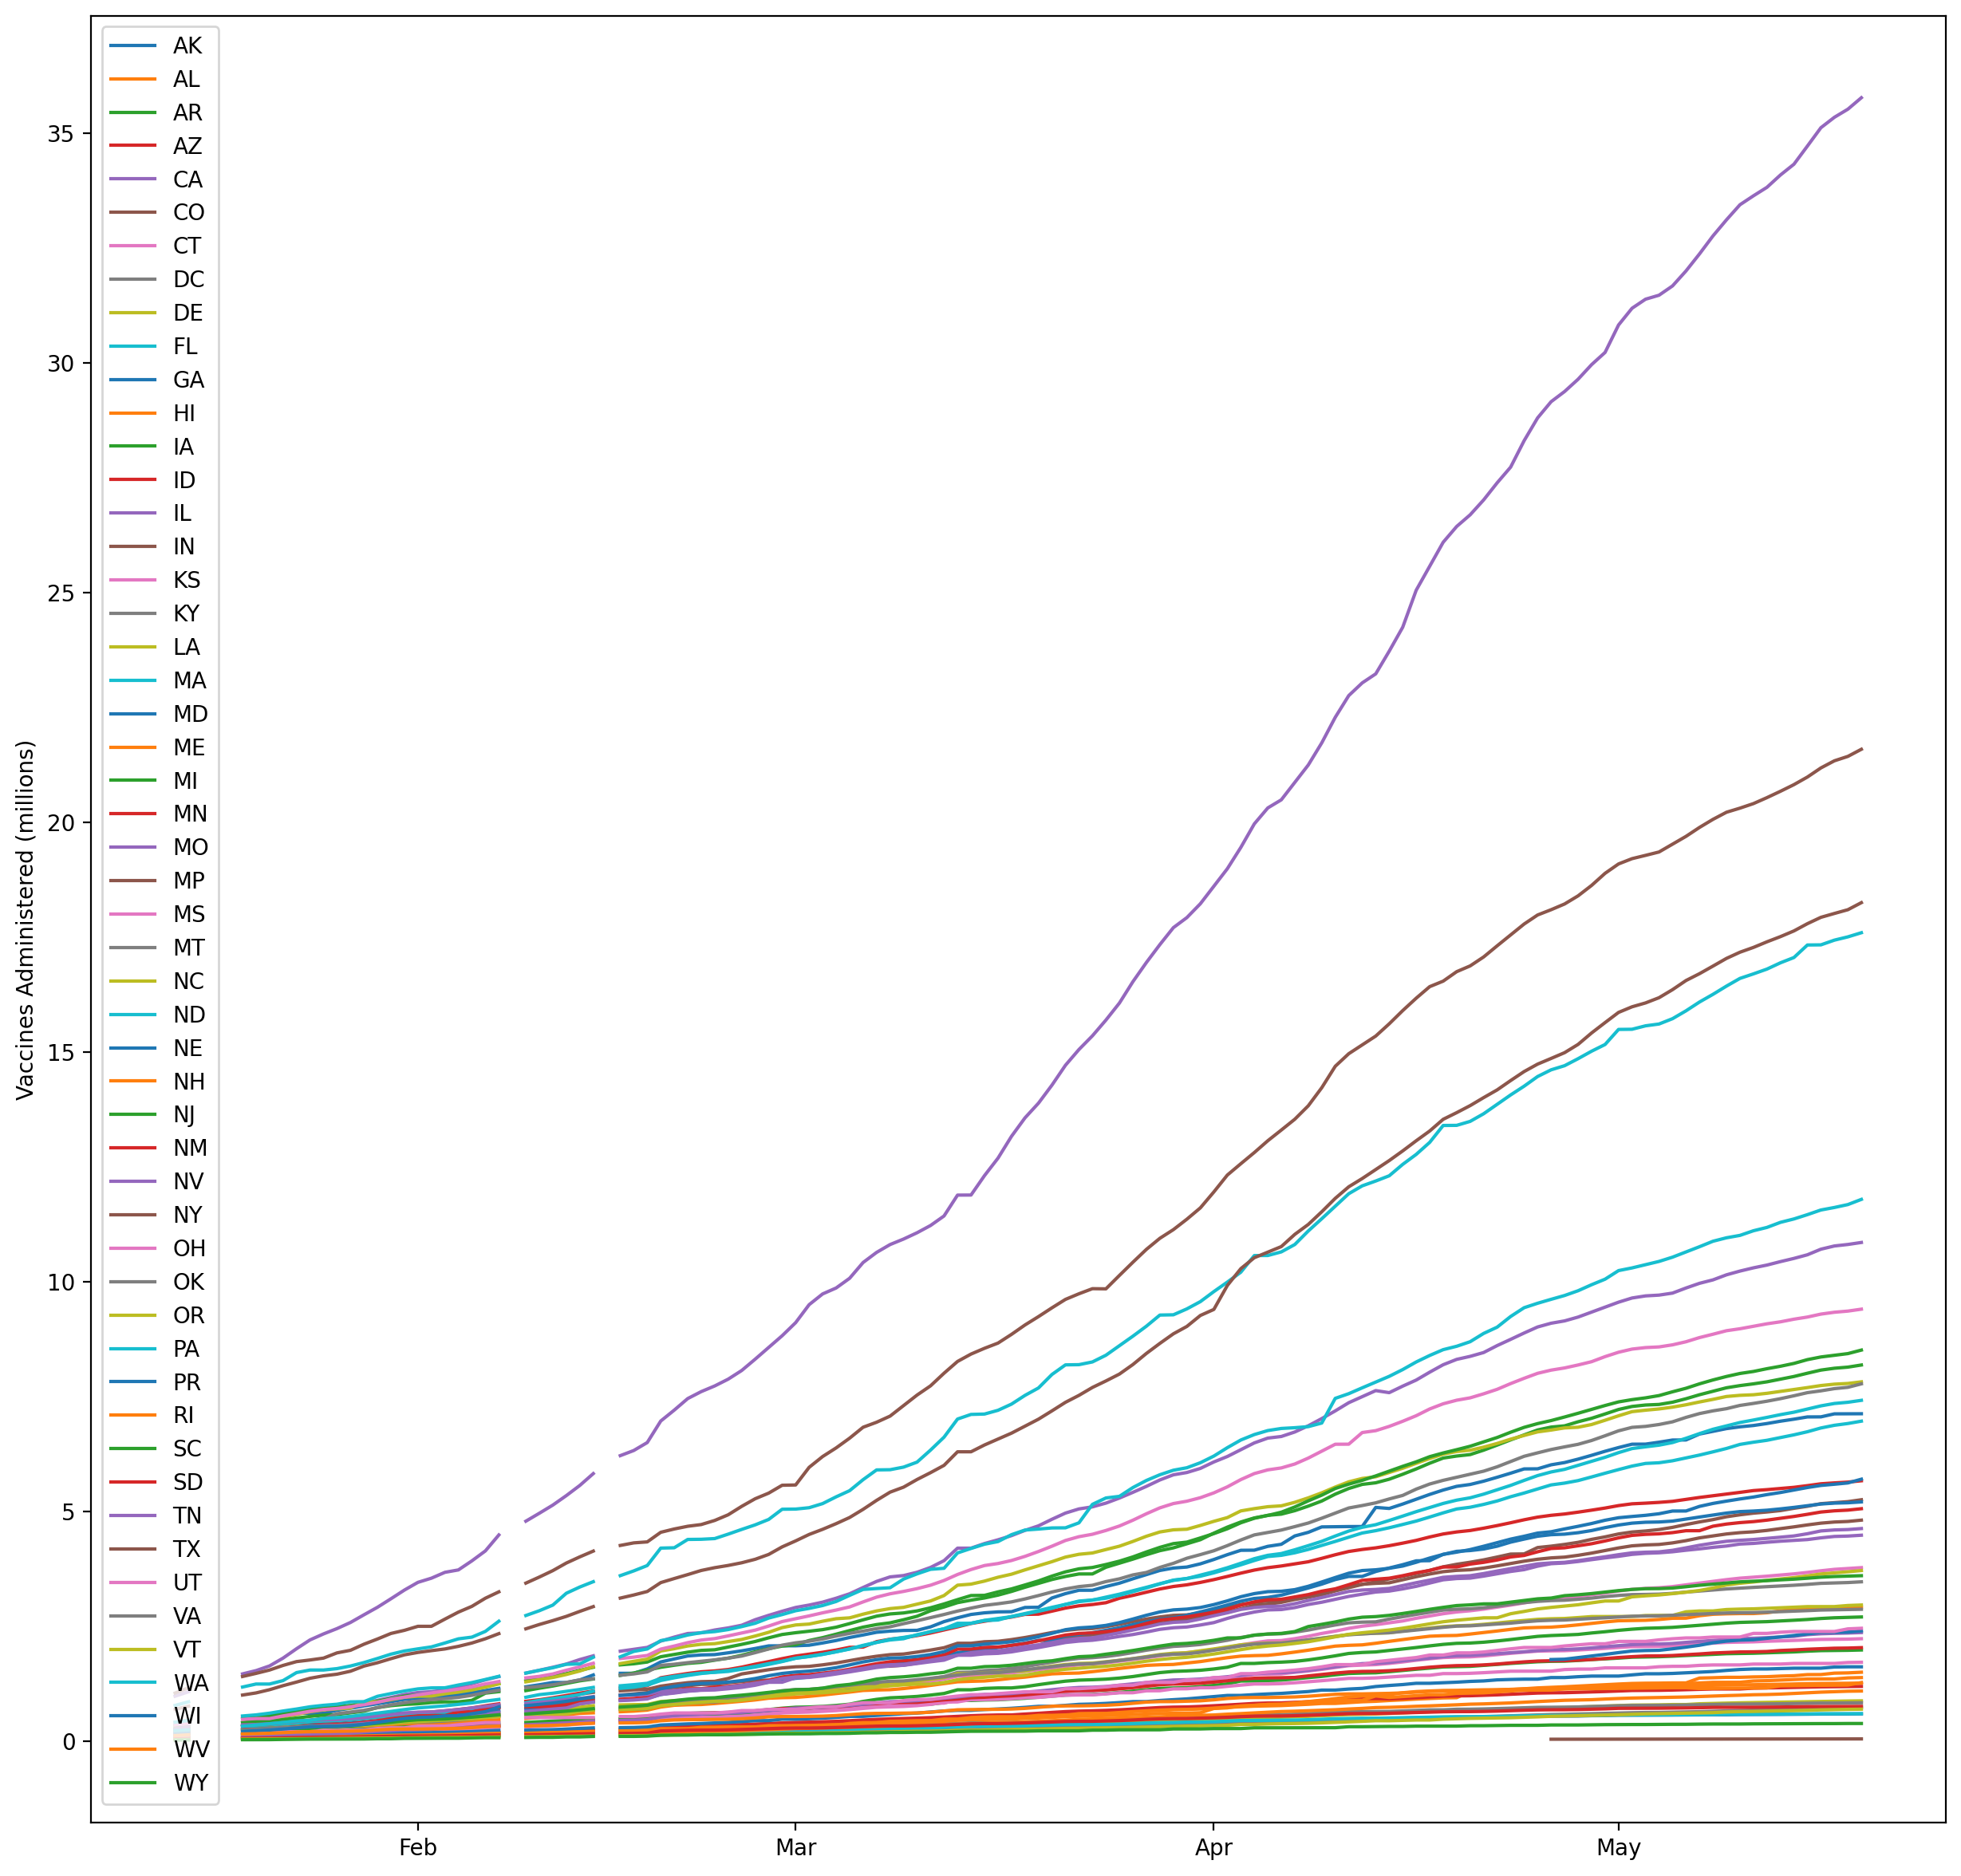

In [8]:
fig, ax = plt.subplots(figsize=(15,15), dpi=200)
ax.plot(vaccine_data)

plt.legend(vaccine_data.columns.values,loc='upper left')


locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.ylabel("Vaccines Administered (millions)")
plt.show()

There is clearly substantial variation across states, as well as decent amount of missing data. However, the plot is not terribly informative. In fact, it is kind of a disaster. Not only are various states clustered together, the default colormap isn't helping, with matplotlib recycling certain colors. While we could play around with the color cycle, that doesn't seem like the best course of action since identifying individual states will remain a challenge with a sample of this size. Probably best to highlight specific states. Using the code below I highlight states of particular interest (in this case, the four most populated):

Text(0, 0.5, 'Vaccines Administered (millions)')

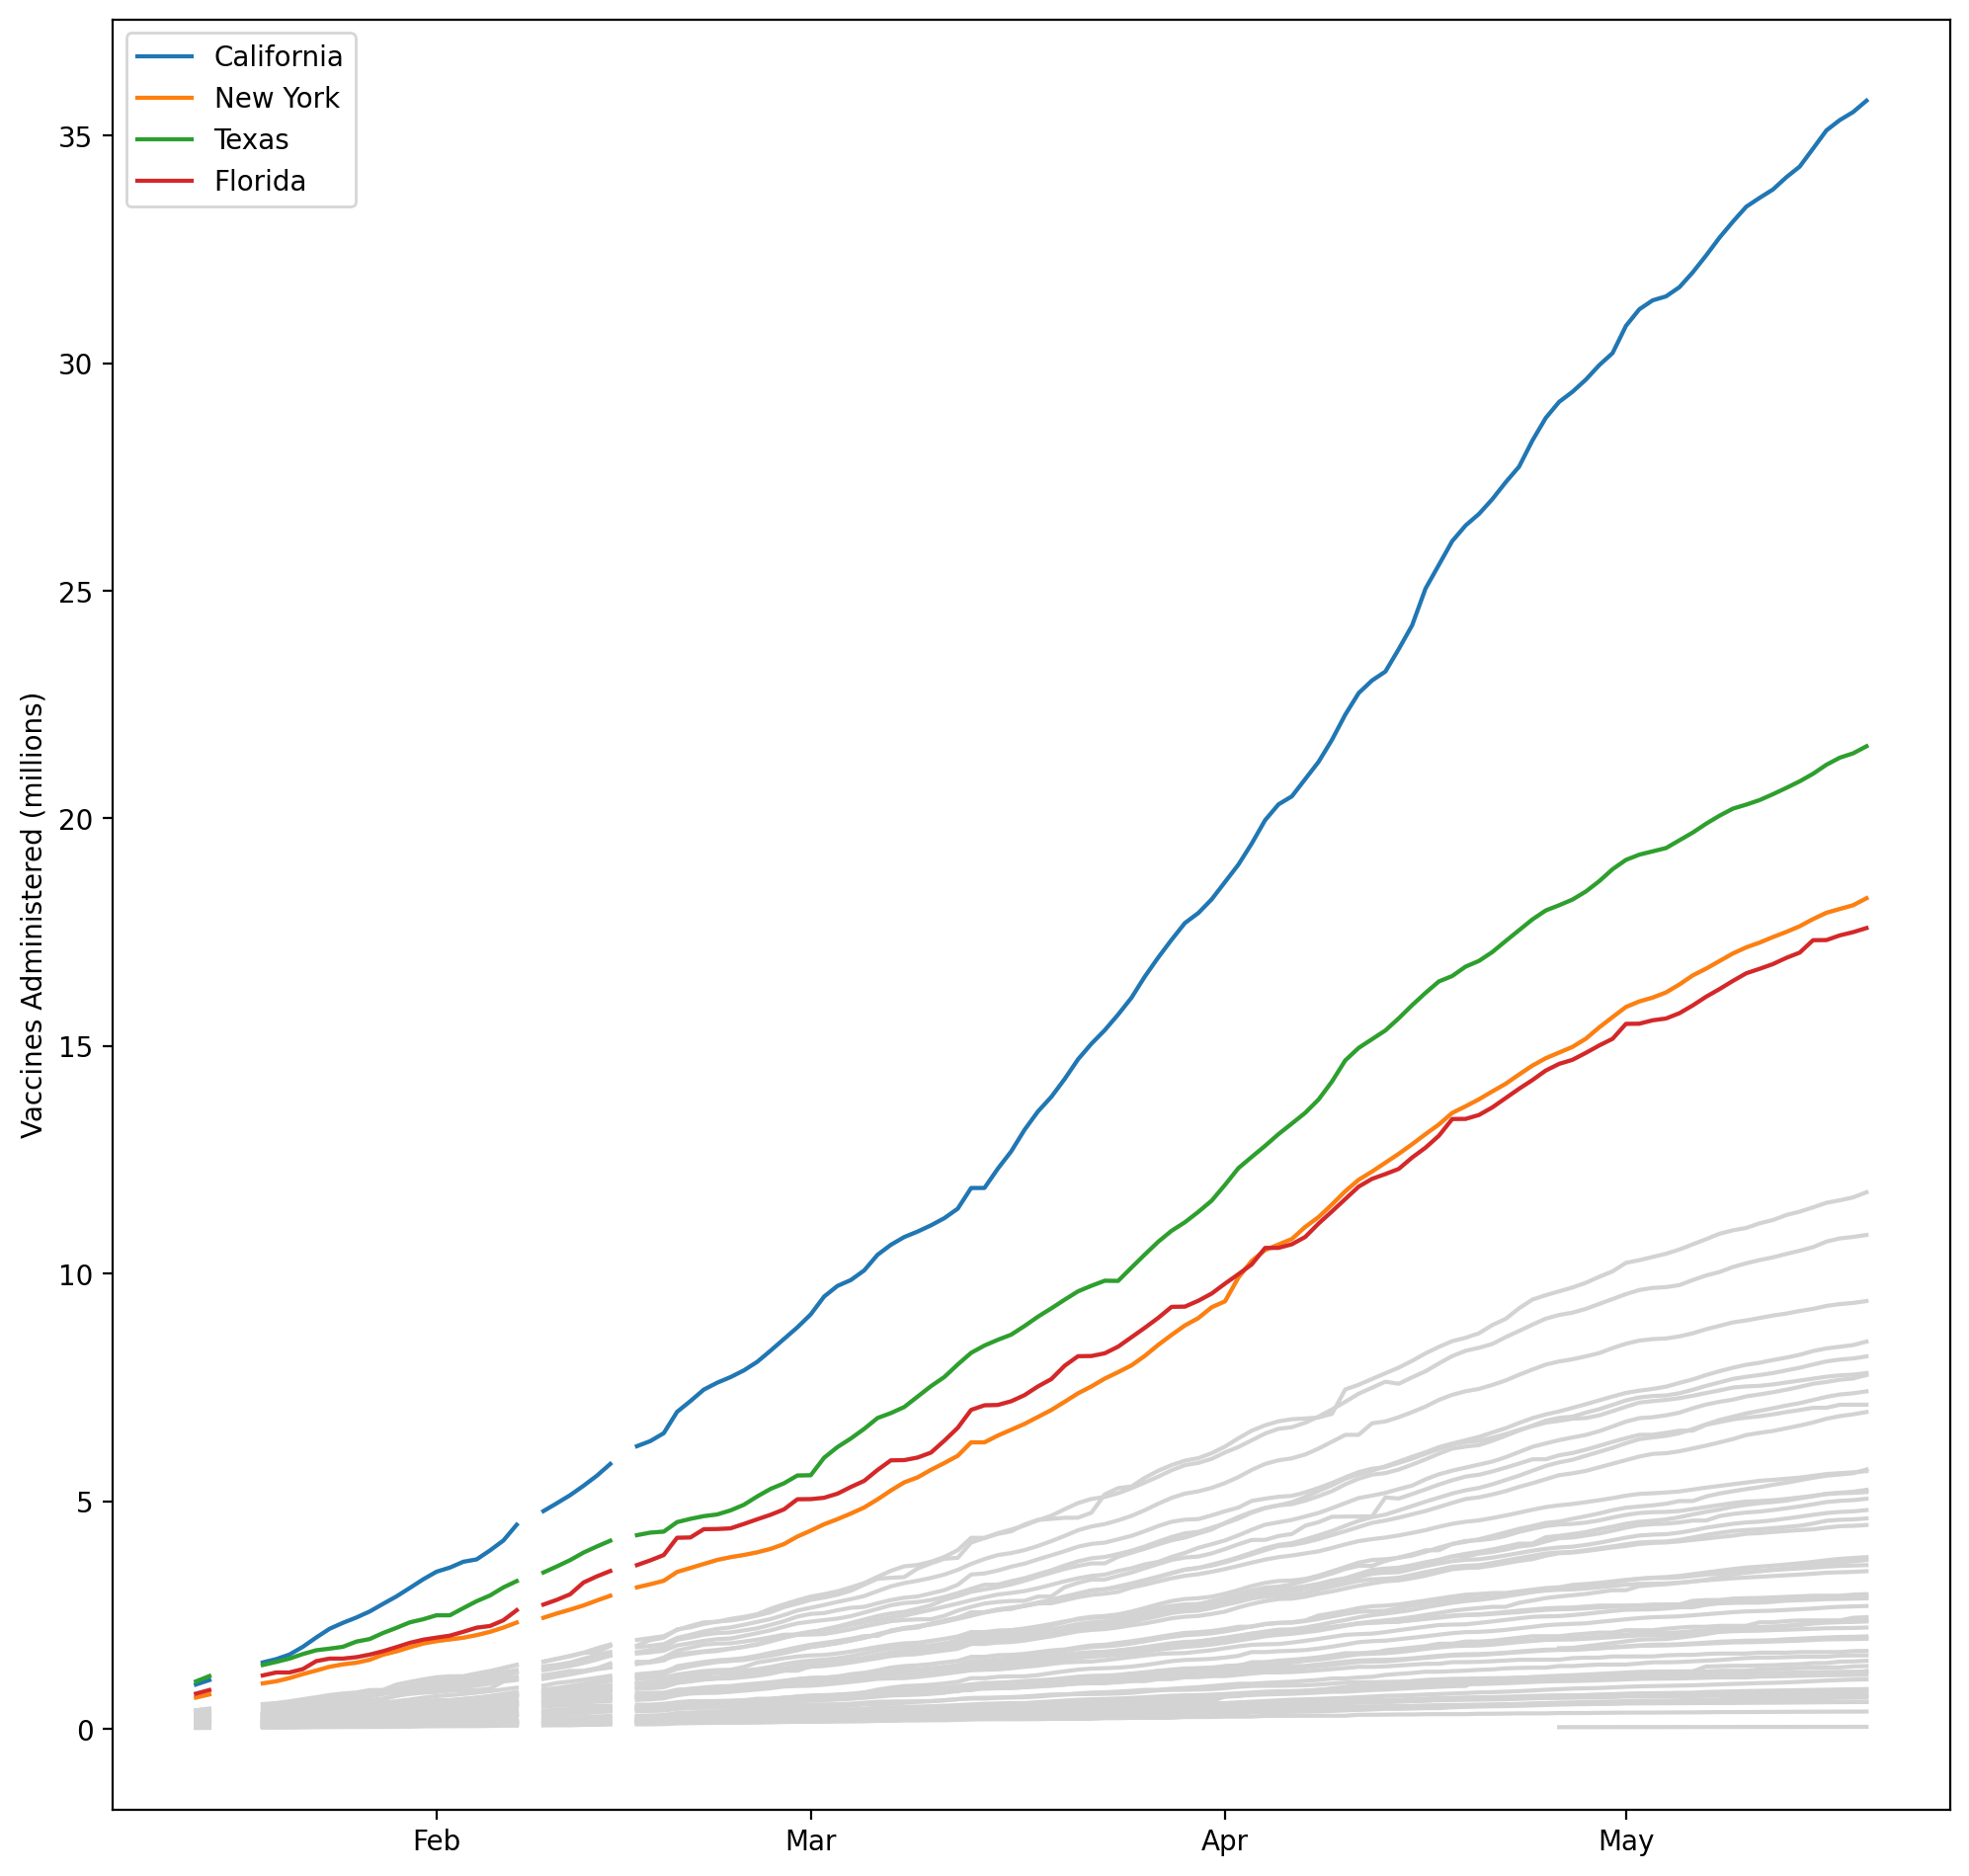

In [9]:
fig, ax = plt.subplots(figsize=(12,12), dpi=200)

locator = mdates.MonthLocator() 
fmt = mdates.DateFormatter('%b')

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
ax.plot(vaccine_data, color='lightgray')
ax.plot(vaccine_data['CA'], label="California")
ax.plot(vaccine_data['NY'], label="New York")
ax.plot(vaccine_data['TX'], label="Texas")
ax.plot(vaccine_data['FL'], label="Florida")
plt.legend()
plt.ylabel("Vaccines Administered (millions)")

The results are not particularly surprising. The most populated states are leading the way when it comes to vaccinations. For a more nuanced analysis, we should probably generate per capita measures and examine the impact of different demographic, political, and economic factors. For that, we need more data.

## Census Data and 2020 Presidential Election Returns 

In order to analyze the impact of income inequality and race on vaccination rates, I collect 2019 data using the Census API below:

In [10]:
statedata = censusdata.download('acs5', 2019, censusdata.censusgeo([('state', '*')]),
                                ['B19013_001E', 'B19083_001E',
                                 'C17002_001E', 'C17002_002E', 'C17002_003E', 'C17002_004E',
                                 'B03002_001E', 'B03002_003E', 'B03002_004E', 'B03002_012E',])

I also rename columns and rescale income and demographic data:

In [11]:
statedata = statedata.rename(columns={'B19013_001E': 'median_HH_income'})
statedata['median_HH_income'] = statedata['median_HH_income'] / 1000
statedata = statedata.rename(columns={'B19083_001E': 'gini_index'})
statedata.gini_index = statedata.gini_index * 100
statedata['percent_below_125_poverty'] = (statedata['C17002_002E'] + statedata['C17002_003E'] + statedata['C17002_004E']) / statedata['C17002_001E'] * 100
statedata['percent_nonhisp_white'] = statedata['B03002_003E'] / statedata['B03002_001E'] * 100
statedata['percent_nonhisp_black'] = statedata['B03002_004E'] / statedata['B03002_001E'] * 100
statedata['percent_hispanic'] = statedata['B03002_012E'] / statedata['B03002_001E'] * 100

In [12]:
for column in ['C17002_001E', 'C17002_002E', 'C17002_003E', 'C17002_004E',
               'B03002_001E', 'B03002_003E', 'B03002_004E', 'B03002_012E',]:
    del statedata[column]

Let's take a quick look at the Census Data:

In [13]:
statedata.describe()

,median_HH_income,gini_index,percent_below_125_poverty,percent_nonhisp_white,percent_nonhisp_black,percent_hispanic
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,62.279423,46.730385,18.031381,66.861113,10.797775,13.552992
std,12.140622,2.313748,6.079306,18.520174,10.570505,15.764870
min,20.539000,42.650000,10.236220,0.955959,0.095798,1.560993
25%,55.338250,45.222500,14.495639,56.370805,3.038652,5.118410
50%,60.981000,46.655000,17.634028,70.053762,7.025340,9.458482
75%,71.384750,47.910000,19.823309,79.543432,14.501342,14.390589
max,86.420000,54.860000,52.895679,93.188952,45.442721,98.718437


Given how polarized the issue of vaccination has become, it's important to control for the political leaning of the electorate. Using the code below, I add data on the Democratic share of the vote in the 2020 presidential elections.

In [14]:
voting2020 = {
    censusdata.censusgeo((('state', '01'),)): 36.57,
    censusdata.censusgeo((('state', '02'),)): 42.77,
    censusdata.censusgeo((('state', '04'),)): 49.36,
    censusdata.censusgeo((('state', '05'),)): 34.78,
    censusdata.censusgeo((('state', '06'),)): 63.48,
    censusdata.censusgeo((('state', '08'),)): 55.40,
    censusdata.censusgeo((('state', '09'),)): 59.26,
    censusdata.censusgeo((('state', '10'),)): 58.74,
    censusdata.censusgeo((('state', '11'),)): 92.8,
    censusdata.censusgeo((('state', '12'),)): 47.86,
    censusdata.censusgeo((('state', '13'),)): 49.47,
    censusdata.censusgeo((('state', '15'),)): 63.73,
    censusdata.censusgeo((('state', '16'),)): 33.07,
    censusdata.censusgeo((('state', '17'),)): 57.54,
    censusdata.censusgeo((('state', '18'),)): 40.96,
    censusdata.censusgeo((('state', '19'),)): 44.89,
    censusdata.censusgeo((('state', '20'),)): 41.56,
    censusdata.censusgeo((('state', '21'),)): 36.15,
    censusdata.censusgeo((('state', '22'),)): 39.85,
    censusdata.censusgeo((('state', '23'),)): 53.09,
    censusdata.censusgeo((('state', '24'),)): 65.36,
    censusdata.censusgeo((('state', '25'),)): 65.60,
    censusdata.censusgeo((('state', '26'),)): 50.62,
    censusdata.censusgeo((('state', '27'),)): 52.40,
    censusdata.censusgeo((('state', '28'),)): 41.06,
    censusdata.censusgeo((('state', '29'),)): 41.41,
    censusdata.censusgeo((('state', '30'),)): 40.55,
    censusdata.censusgeo((('state', '31'),)): 39.17,
    censusdata.censusgeo((('state', '32'),)): 50.06,
    censusdata.censusgeo((('state', '33'),)): 52.71,
    censusdata.censusgeo((('state', '34'),)): 57.33,
    censusdata.censusgeo((('state', '35'),)): 54.29,
    censusdata.censusgeo((('state', '36'),)): 60.86,
    censusdata.censusgeo((('state', '37'),)): 48.59,
    censusdata.censusgeo((('state', '38'),)): 31.76,
    censusdata.censusgeo((('state', '39'),)): 45.24,
    censusdata.censusgeo((('state', '40'),)): 32.29,
    censusdata.censusgeo((('state', '41'),)): 56.45,
    censusdata.censusgeo((('state', '42'),)): 50.01,
    censusdata.censusgeo((('state', '44'),)): 59.39,
    censusdata.censusgeo((('state', '45'),)): 43.43,
    censusdata.censusgeo((('state', '46'),)): 35.61,
    censusdata.censusgeo((('state', '47'),)): 37.45,
    censusdata.censusgeo((('state', '48'),)): 46.48,
    censusdata.censusgeo((('state', '49'),)): 37.65,
    censusdata.censusgeo((('state', '50'),)): 66.09,
    censusdata.censusgeo((('state', '51'),)): 54.11,
    censusdata.censusgeo((('state', '53'),)): 57.97,
    censusdata.censusgeo((('state', '54'),)): 29.69,
    censusdata.censusgeo((('state', '55'),)): 49.45,
    censusdata.censusgeo((('state', '56'),)): 26.55,
}
voting2020 = pd.DataFrame.from_dict(voting2020, orient='index')
statedata['percent_democratic_pres_2020'] = voting2020

In [15]:
statedata = statedata.reindex(columns=['percent_democratic_pres_2020', 'population_size', 'median_HH_income', 'percent_below_125_poverty', 'gini_index', 'percent_nonhisp_white', 'percent_nonhisp_black', 'percent_hispanic'])
statedata.describe()

,percent_democratic_pres_2020,population_size,median_HH_income,percent_below_125_poverty,gini_index,percent_nonhisp_white,percent_nonhisp_black,percent_hispanic
count,51.000000,0.0,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,48.646275,NaN,62.279423,18.031381,46.730385,66.861113,10.797775,13.552992
std,12.095424,NaN,12.140622,6.079306,2.313748,18.520174,10.570505,15.764870
min,26.550000,NaN,20.539000,10.236220,42.650000,0.955959,0.095798,1.560993
25%,40.200000,NaN,55.338250,14.495639,45.222500,56.370805,3.038652,5.118410
50%,49.360000,NaN,60.981000,17.634028,46.655000,70.053762,7.025340,9.458482
75%,56.890000,NaN,71.384750,19.823309,47.910000,79.543432,14.501342,14.390589
max,92.800000,NaN,86.420000,52.895679,54.860000,93.188952,45.442721,98.718437


We've hit a little snag at this point. The Covid data and Census data use different variables to identify states. Whereas the covid data uses state acronyms, the census data uses the full name and has these weird identifiers. Fortunately, I have an excel sheet handy that maps states to their acronyms.

In [16]:
acronyms = pd.read_csv("https://raw.githubusercontent.com/sjillani87/Covid-19-Vaccination-Data-Analysis/main/US%20State%20Acronyms.csv")
acronyms.columns=['state', 'acronym']
acronyms=acronyms.set_index('state')

Now we turn to cleaning the Census data. Unfortunately, the Census database's index object is kind of weird. I tried different ways of recovering the state name, but wasn't successful. As a result, I had to use a pretty roundabout way of recovering the state's name: I reset the index, create a column that is is a string version of the original index, and then use basic operations to clean the string. Once I have the state's name, I set it as the dataframe index.

In [17]:
statedata.reset_index(inplace=True)
statedata['state']=statedata['index'].astype(str)
statedata['state'] = statedata['state'].str.split(':').str[0]
statedata['state']=statedata['state'].str.strip()
statedata=statedata.set_index('state')
del statedata['index']

And now we have a dataframe that we can merge with Covid Act Now's data to do some rudimentary analysis with.

In [18]:
prelim_data=statedata.merge(acronyms, left_index=True, right_on='state')

## Statistical Analysis

For our analysis, let's just work with the latest data. Using Covid Act Now's API, I scrape the latest vaccination data. 

In [19]:
covid_data = pd.read_csv("https://api.covidactnow.org/v2/states.csv?apiKey=011be03f8a4b44d186e6d55dda414ff2", parse_dates=True, squeeze=True)
covid_data = covid_data.rename(columns={'state': 'acronym'})
covid_data.set_index('acronym', inplace=True)

In [20]:
covid_data.head()

,fips,country,county,level,lat,locationId,long,population,metrics.testPositivityRatio,metrics.testPositivityRatioDetails.source,...,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,lastUpdatedDate,url,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered
acronym,,,,,,,,,,,,,,,,,,,,,
AK,2,US,NaN,state,NaN,iso1:us#iso2:us-ak,NaN,731545,0.009123,other,...,51,814795,342656,294058,2021-06-08,https://covidactnow.org/us/alaska-ak,0.468400,0.401968,0,622928
AL,1,US,NaN,state,NaN,iso1:us#iso2:us-al,NaN,4903185,0.048806,other,...,739,4637330,1774139,1442775,2021-06-08,https://covidactnow.org/us/alabama-al,0.361834,0.294253,19,3036419
AR,5,US,NaN,state,NaN,iso1:us#iso2:us-ar,NaN,3017804,0.039356,other,...,62,2793160,1210066,958477,2021-06-08,https://covidactnow.org/us/arkansas-ar,0.400976,0.317607,3,2111327
AZ,4,US,NaN,state,NaN,iso1:us#iso2:us-az,NaN,7278717,0.040334,other,...,374,7893465,3432146,2689635,2021-06-08,https://covidactnow.org/us/arizona-az,0.471532,0.369520,0,6090510
CA,6,US,NaN,state,NaN,iso1:us#iso2:us-ca,NaN,39512223,0.007189,other,...,1164,47955210,22957251,17751394,2021-06-08,https://covidactnow.org/us/california-ca,0.581016,0.449263,21,39541180


This dataset also provides population statistics, so let's take a quick glance at how the states compare when it comes to vaccination per capita.

In [21]:
covid_data['vaccination_rate'] = covid_data['actuals.vaccinesAdministered'] / covid_data['population']

<AxesSubplot:xlabel='acronym', ylabel='vaccination_rate'>

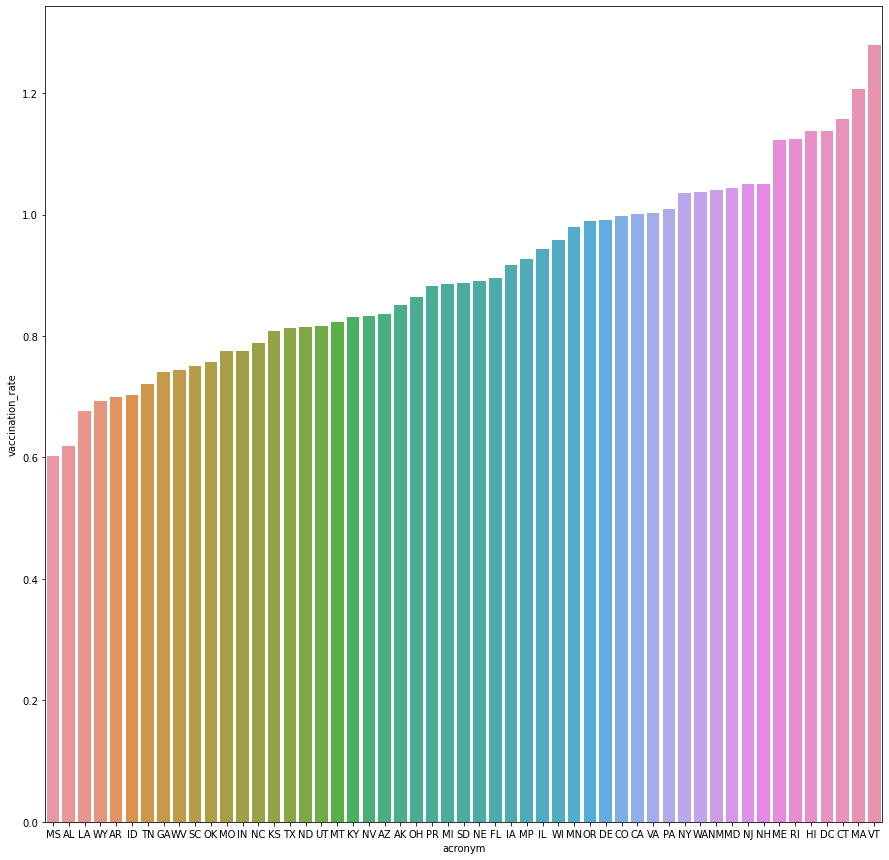

In [22]:
result = covid_data.groupby(["acronym"])['vaccination_rate'].aggregate(np.median).reset_index().sort_values('vaccination_rate')
fig_dims = (15, 15)
fig, ax = plt.subplots(figsize=fig_dims)
sn.barplot(x='acronym', y="vaccination_rate", data=result, order=result['acronym'])

Blue states seem to be leading the way, which is not particularly surprising. Let's proceed with the analysis and figure out the extent to which race and income inequality are driving differences among states. Using the code below, I merge the current covid data with data from the Census. I also rename some columns to facilitate subsequent analysis.

In [23]:
mergedDF = prelim_data.reset_index().merge(covid_data, on='acronym', how='left').set_index('state')
mergedDF.rename(columns={'actuals.deaths':'actual_deaths', 'actuals.cases':'actual_cases', 'actuals.newCases':'actual_newCases'}, inplace=True)

In [24]:
list(mergedDF.columns)

['percent_democratic_pres_2020',
 'population_size',
 'median_HH_income',
 'percent_below_125_poverty',
 'gini_index',
 'percent_nonhisp_white',
 'percent_nonhisp_black',
 'percent_hispanic',
 'acronym',
 'fips',
 'country',
 'county',
 'level',
 'lat',
 'locationId',
 'long',
 'population',
 'metrics.testPositivityRatio',
 'metrics.testPositivityRatioDetails.source',
 'metrics.caseDensity',
 'metrics.contactTracerCapacityRatio',
 'metrics.infectionRate',
 'metrics.infectionRateCI90',
 'metrics.icuHeadroomRatio',
 'metrics.icuHeadroomDetails.currentIcuCovid',
 'metrics.icuHeadroomDetails.currentIcuCovidMethod',
 'metrics.icuHeadroomDetails.currentIcuNonCovid',
 'metrics.icuHeadroomDetails.currentIcuNonCovidMethod',
 'metrics.icuCapacityRatio',
 'riskLevels.overall',
 'riskLevels.testPositivityRatio',
 'riskLevels.caseDensity',
 'riskLevels.contactTracerCapacityRatio',
 'riskLevels.infectionRate',
 'riskLevels.icuHeadroomRatio',
 'riskLevels.icuCapacityRatio',
 'actual_cases',
 'actual_

In [25]:
result = sm.ols(formula=("vaccination_rate ~ median_HH_income"
                         "+ percent_nonhisp_black + percent_hispanic + percent_democratic_pres_2020"), data=mergedDF).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       vaccination_rate   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     99.42
Date:                Tue, 08 Jun 2021   Prob (F-statistic):           9.70e-22
Time:                        17:00:33   Log-Likelihood:                 79.120
No. Observations:                  50   AIC:                            -148.2
Df Residuals:                      45   BIC:                            -138.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.3258      0.050      6.508      0.000       0.225       0.427
median_HH_income                 0.0006      0.001      0.628      0.533      -0.001       0.003
percent_nonhisp_black           -0.0070      0.001     -8.176      0.000      -0.009      -0.005
percent_hispanic                -0.0027      0.001     -3.411      0.001      -0.004      -0.001
percent_democratic_pres_2020     0.0133      0.001     12.971      0.000       0.011       0.015
==============================================================================
Omnibus:                        6.370   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                2.665
Skew:                           0.244   Prob(JB):                        0.264
Kurtosis:                       1.980   Cond. No.                         550.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This preliminary analysis suggests that the political leaning of the eletorate and the percentage of the population that is black and hispanic are systematically related to differences in vaccination rates across states. The impact of partisanship dwarfs that of race (shocking, I tell ya!). However, these findings should be taken with a grain of salt: the sample size is really not that large and since we're working with cross-sectional data, we can't even begin to establish causality. Perhaps it's time to go down to the county level!